In [1]:
import sys
import os
import re
import gc
import json
import logging
import requests
import itertools
import numba

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse.csr import csr_matrix
from time import sleep


from tqdm.auto import trange, tqdm
from collections import Counter, defaultdict
from scipy.sparse import hstack
import pickle
from torch.utils.data import Dataset
from glob import glob
from IPython.display import display as ipython_displpay
from IPython.display import HTML

In [2]:
prefix = os.getcwd().split('jdi-qasp-ml')[0]
sys.path.append(os.path.join(prefix, 'jdi-qasp-ml'))

model_path = os.path.join(prefix, 'jdi-qasp-ml', 'HTML5_model/model')
dataset_path = os.path.join(prefix, 'jdi-qasp-ml', 'data/html5_dataset')

In [133]:
DATASET_NAME = 'html-test-jdi'
WAIT_TIME_SECONDS = 7
SITE_URL = 'https://jdi-testing.github.io/jdi-light/html5.html'
PREDICT_URL = 'http://localhost:5050/html5-predict'

LOGIN = 'Roman'
PASSWORD = 'Jdi1234'
SAVE_SCREEN = True
WAIT_TIME_SECONDS = 2
# HEADLESS = True

In [134]:
from utils.dataset_builder import DatasetBuilder
from utils.common import maximize_window 

In [14]:
class DSBuilder(DatasetBuilder):
    def setUp(self, driver):
        """
            This method may be overwitten if you need to login to the site
            and navigate to a specific url,
            otherwise it just returns 
        """
        
        driver.set_window_size(width=1500, height=15000)
        self.driver.get(self.url)
        driver.find_element_by_id("user-icon").click()
        driver.find_element_by_id("name").send_keys(LOGIN)
        driver.find_element_by_id("password").send_keys(PASSWORD)
        driver.find_element_by_id("login-button").click()
        sleep(WAIT_TIME_SECONDS)
        driver.find_element_by_xpath("/html/body/div/div[1]/div/div[1]/div/div[1]/ul/li[5]/a/div").click() #path to elements packs
        driver.find_element_by_xpath("/html/body/div/div[1]/div/div[1]/div/div[1]/ul/li[5]/ul/li[1]/a").click() #path to mui
        sleep(2.0)
        maximize_window(driver=driver, extend_pix=0)
        sleep(2.0)
        
with DSBuilder(url=SITE_URL, dataset_name=DATASET_NAME, headless=True, dataset_root_path=dataset_path) as builder:
    df = builder.dataset
    dataset_json = builder.dataset_json

2022-01-12 23:15:00,894 -INFO - dataset_builder.py:100 - Dataset name: html-test-jdi
2022-01-12 23:15:00,896 -INFO - dataset_builder.py:110 - Create directories to save the dataset
2022-01-12 23:15:00,898 -INFO - dataset_builder.py:152 - Creating driver
2022-01-12 23:15:01,781 -INFO - dataset_builder.py:164 - Chrome web driver is created


ipykernel_launcher:11: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
ipykernel_launcher:12: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
ipykernel_launcher:13: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
ipykernel_launcher:14: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
ipykernel_launcher:16: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
ipykernel_launcher:17: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead


2022-01-12 23:15:07,802 -INFO - common.py:22 - Window maximized
2022-01-12 23:15:09,808 -INFO - dataset_builder.py:167 - save scrinshot: /Users/Mikhail_Bulgakov/GitRepo/jdi-qasp-ml/data/html5_dataset/images/html-test-jdi.png
2022-01-12 23:15:14,892 -INFO - dataset_builder.py:211 - Collect features using JS script
2022-01-12 23:15:15,412 -INFO - dataset_builder.py:219 - Save html to /Users/Mikhail_Bulgakov/GitRepo/jdi-qasp-ml/data/html5_dataset/html/html-test-jdi.html
2022-01-12 23:15:15,423 -INFO - dataset_builder.py:231 - Save peakle to /Users/Mikhail_Bulgakov/GitRepo/jdi-qasp-ml/data/html5_dataset/df/html-test-jdi.pkl
2022-01-12 23:15:15,425 -INFO - dataset_builder.py:234 - No attributes: (255, 14)
2022-01-12 23:15:15,472 -INFO - dataset_builder.py:125 - Close web driver


In [15]:
dataset_path

'/Users/Mikhail_Bulgakov/GitRepo/jdi-qasp-ml/data/html5_dataset'

In [16]:
d = pd.DataFrame(dataset_json)
d[d.html.apply(lambda x: True if '<input type="button"' in x else False)].tail(3)

,attributes,displayed,element_id,height,html,onmouseenter,onmouseover,parent_id,style,tag_name,text,width,x,y
206,{'class': 'html-left'},True,3460527557185148978008213568,477.59375,"<div class=""html-left"">\n ...",None,None,3427265303185148978963461876,"[accent-color, align-content, align-items, ali...",DIV,BUTTON\n\n\n\n\nTAG BUTTON\nBIG BLUE BUTTON\n\...,283.187500,363.0,378.187500
208,"{'class': 'uui-button red', 'onclick': 'alert(...",True,0795996329185148975301459196,34.00000,"<input type=""button"" value=""Big Red Button-Inp...",None,None,3460527557185148978008213568,"[accent-color, align-content, align-items, ali...",INPUT,,163.421875,363.0,417.984375
211,"{'class': 'uui-button grey', 'disabled': '', '...",True,6561826135185148979940662626,34.00000,"<input type=""button"" value=""Disabled Button-In...",None,None,3460527557185148978008213568,"[accent-color, align-content, align-items, ali...",INPUT,,171.906250,363.0,469.984375


In [98]:
from utils.dataset import HTML5_JDNDataset
dataset = HTML5_JDNDataset(
        datasets_list=[DATASET_NAME],
        dataset_type="html5",
        rebalance_and_shuffle=False,
    )

100%|██████████| 1/1 [00:01<00:00,  1.20s/it, /Users/Mikhail_Bulgakov/GitRepo/jdi-qasp-ml/data/html5_dataset/df/html-test-jdi.pkl]

2022-01-12 23:32:27,134 -INFO - dataset.py:210 - self.df.shape: (668, 33)
2022-01-12 23:32:27,135 -INFO - dataset.py:101 - Check for duplicates...
2022-01-12 23:32:27,137 -INFO - dataset.py:105 - Check for duplicates is OK
2022-01-12 23:32:27,138 -INFO - dataset.py:214 - Calculating features...
2022-01-12 23:32:27,228 -INFO - dataset_collector.py:177 - X: (668, 79)
2022-01-12 23:32:27,230 -INFO - dataset.py:218 - Features have calculated succesfully!


In [99]:
print(dataset.df.shape)
print(dataset.X.shape)

(668, 33)
(668, 79)


In [100]:
dataset.df[dataset.df.element_id == "0795996329185148975301459196"].index

Index(['0795996329185148975301459196'], dtype='object', name='element_id')

In [101]:
dataset.X.loc["0795996329185148975301459196"][dataset.X.loc["0795996329185148975301459196"]==1]

tag_INPUT      1
attr_value     1
type_button    1
Name: 0795996329185148975301459196, dtype: int64

In [102]:
pkl_filename = "DT_model.pkl"
with open(f"{model_path}/{pkl_filename}", "rb") as file:
    model = pickle.load(file)

In [103]:
html5_classes_path = "/Users/Mikhail_Bulgakov/GitRepo/jdi-qasp-ml/data/html5_dataset/classes.txt"
with open(html5_classes_path, "r") as f:
        lines = f.readlines()
        encoder_dict = {line.strip(): i for i, line in enumerate(lines)}
        decoder_dict = {v: k for k, v in encoder_dict.items()}

In [104]:
# pd.Series(model.predict(dataset.X)).apply(lambda x: decoder_dict[x]).unique()

In [113]:
res_dataset = dataset.X.copy()
res_dataset.shape

(668, 79)

In [114]:
res_dataset["pred"] = pd.Series(model.predict(res_dataset)).apply(lambda x: decoder_dict.get(x, "n/a")).values
res_dataset.head()

,tag_HTML,tag_HEAD,tag_META,tag_TITLE,tag_STYLE,tag_BODY,tag_DIV,tag_LABEL,tag_INPUT,tag_DATALIST,...,type_range,type_radio,type_month,type_checkbox,type_reset,type_number,type_week,is_checkbox_in_childs,is_radio_in_childs,pred
element_id,,,,,,,,,,,,,,,,,,,,,
0002037534185148975896194112,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,title
0007072414185148970880802200,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,n/a
0019757941185148975041962840,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,link
0020281423185148973331208162,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,n/a
0042530667185148979837533652,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,n/a


In [115]:
res_dataset.pred.unique()

array(['title', 'n/a', 'link', 'text', 'textfield', 'fileinput', 'label',
       'button', 'datetimeselector', 'textarea', 'checklist', 'checkbox',
       'radiobutton', 'range', 'dropdown', 'colorpicker', 'multiselector',
       'datalist', 'multidropdown', 'radiobuttongroup', 'numberselector',
       'progressbar'], dtype=object)

In [135]:
%%time

response = requests.post(
    PREDICT_URL, data=json.dumps(dataset_json)
)

if response.status_code == 200:
    display(json.loads(response.text))
else:
    raise Exception(response.text)

[{'element_id': '1227549143185148971821458374',
  'x': 363.0,
  'y': 3816.75,
  'width': 283.1875,
  'height': 130.0,
  'predicted_label': 'checklist',
  'predicted_probability': 1.0,
  'sort_key': 36814.375},
 {'element_id': '6906657592185148972816339672',
  'x': 363.0,
  'y': 4129.546875,
  'width': 283.1875,
  'height': 104.0,
  'predicted_label': 'radiobuttongroup',
  'predicted_probability': 1.0,
  'sort_key': 29451.5},
 {'element_id': '4844355928185148971766817755',
  'x': 363.0,
  'y': 186.0,
  'width': 283.1875,
  'height': 79.1875,
  'predicted_label': 'title',
  'predicted_probability': 1.0,
  'sort_key': 22424.91015625},
 {'element_id': '4999792534185148976501643162',
  'x': 696.203125,
  'y': 1359.375,
  'width': 610.796875,
  'height': 36.0,
  'predicted_label': 'text',
  'predicted_probability': 1.0,
  'sort_key': 21988.6875},
 {'element_id': '6395437581185148977247508649',
  'x': 696.203125,
  'y': 1257.375,
  'width': 610.796875,
  'height': 36.0,
  'predicted_label': '

CPU times: user 124 ms, sys: 15.1 ms, total: 139 ms
Wall time: 1.93 s


In [136]:
from utils.common import load_gray_image
from matplotlib.patches import Rectangle

In [137]:
df = pd.read_pickle(f'{dataset_path}/df/{DATASET_NAME}.pkl')[['element_id', 'tag_name']]
df['element_id'] = df['element_id'].astype(str)
preds = pd.DataFrame(json.loads(response.text))
preds['element_id'] = preds['element_id'].astype(str)
predictions_df = preds.merge(df, on='element_id')
predictions_df.head()

,element_id,x,y,width,height,predicted_label,predicted_probability,sort_key,tag_name
0,1227549143185148971821458374,363.000000,3816.750000,283.187500,130.0000,checklist,1.0,36814.375000,DIV
1,6906657592185148972816339672,363.000000,4129.546875,283.187500,104.0000,radiobuttongroup,1.0,29451.500000,DIV
2,4844355928185148971766817755,363.000000,186.000000,283.187500,79.1875,title,1.0,22424.910156,H1
3,4999792534185148976501643162,696.203125,1359.375000,610.796875,36.0000,text,1.0,21988.687500,P
4,6395437581185148977247508649,696.203125,1257.375000,610.796875,36.0000,text,1.0,21988.687500,P


In [138]:
predictions_df.predicted_label.unique()

array(['checklist', 'radiobuttongroup', 'title', 'text', 'textarea',
       'link', 'datetimeselector', 'numberselector', 'button',
       'fileinput', 'multiselector', 'label', 'textfield', 'datalist',
       'progressbar', 'dropdown', 'range', 'colorpicker', 'checkbox',
       'radiobutton', 'multidropdown'], dtype=object)

<AxesSubplot:>

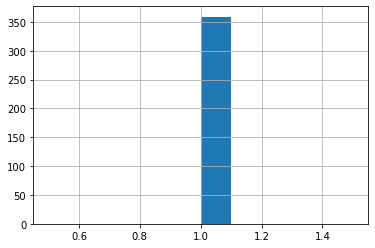

In [139]:
predictions_df['predicted_probability'].hist()

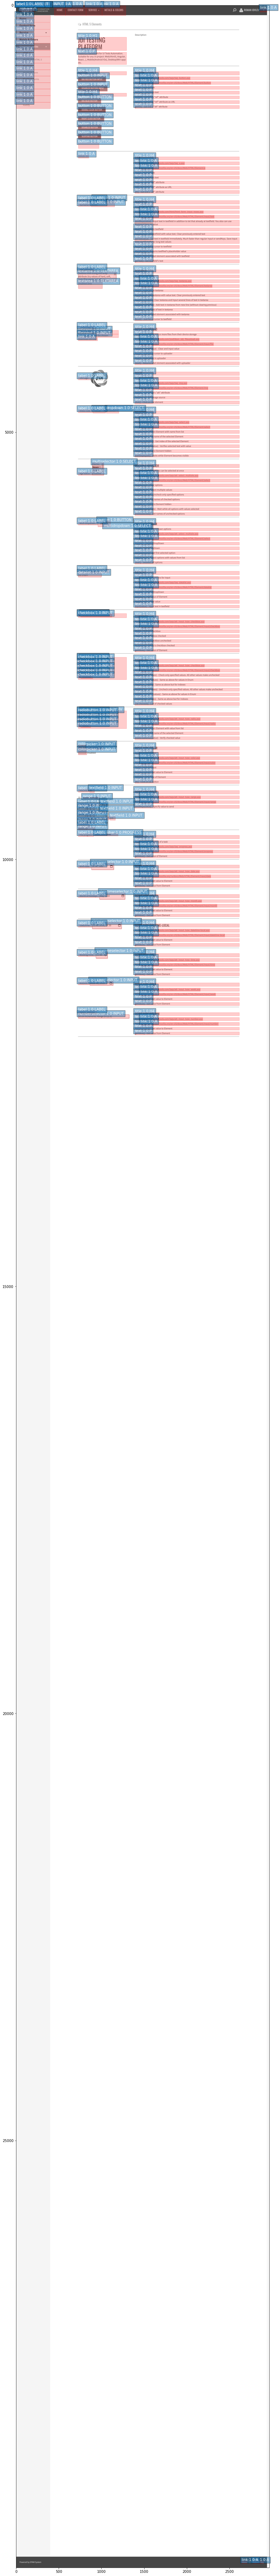

In [140]:
img = load_gray_image(f'{dataset_path}/images/{DATASET_NAME}.png')
plt.figure(figsize=(13,300))
plt.imshow(img, cmap='gray')

axes = plt.gca()

for _, r in predictions_df.iterrows():
        patch = Rectangle((r.x*2, r.y*2), r.width*2, r.height*2, alpha=.2, color='red')
        axes.add_patch(patch)
        axes.text(r.x*2, r.y*2, 
                str(r.predicted_label) + ':' +str(round(r.predicted_probability, 2)) + ':' + r.tag_name, 
                backgroundcolor='black', 
                color='white',
                bbox=dict(alpha=0.5))